In [2]:
# Cell 1: Install dependencies (run in Google Colab)
# --------------------------------------------------
# Run this cell first in Colab to install required packages.
!pip install --quiet git+https://github.com/qubvel/segmentation_models.pytorch --upgrade
!pip install --quiet timm
!pip install --quiet einops
!pip install --quiet albumentations
!pip install --quiet rasterio
!pip install -q --upgrade albumentations==1.4.14 albucore==0.0.12


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: Cannot install albucore==0.0.12 and albumentations==1.4.14 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


In [5]:
# --- Ensure required dependencies are installed ---
!pip install -q torchmetrics==1.8.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 24.7 MB/s eta 0:00:00


In [6]:
# Cell 2: Imports
# --------------------------------------------------
import os
import random
from glob import glob
from pathlib import Path
from typing import Optional, List, Tuple


import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms


import timm
from einops import rearrange
import albumentations as A
from albumentations.pytorch import ToTensorV2
# For binary segmentation (foreground vs background)

from torchmetrics.classification import BinaryJaccardIndex
from torchmetrics.functional.segmentation import dice_score



In [7]:
# Cell 3: Utility functions (seed, visualization)
# --------------------------------------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

def show_image(img_tensor_or_array, title=None):
    if isinstance(img_tensor_or_array, torch.Tensor):
        img = img_tensor_or_array.detach().cpu().numpy()
        if img.shape[0] == 1:
            img = img[0]
        else:
            img = np.transpose(img, (1,2,0))
    else:
        img = img_tensor_or_array
    plt.figure(figsize=(6,6))
    if img.ndim==2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

In [8]:
# Cell 4: Parameters (change these to your needs)
# --------------------------------------------------
class CFG:
    # dataset
    DATA_ROOT = '/content/dataset'  # put dataset here or automatic downloader will try
    USE_EUROSAT = True   # If True tries to use torchvision.datasets.EuroSAT (satellite)
    IMAGE_DIR = 'images'
    MASK_DIR = 'masks'

    # training
    SEED = 42
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    NUM_CLASSES = 1  # binary segmentation (change to >1 for multi-class)
    BATCH_SIZE = 8
    NUM_WORKERS = 4
    EPOCHS = 40

    # model
    PRETRAINED_ENCODER = True  # if True uses pretrained backbone
    ENCODER_NAME = 'resnet34'  # used for timm backbone
    TRANSFORMER_EMBED_DIM = 256

    # optimizer
    OPTIM='AdamW'  # choices: Adam, AdamW, RMSprop
    LR = 1e-4
    WEIGHT_DECAY = 1e-5

    # scheduler & warmup
    USE_WARMUP = True
    WARMUP_EPOCHS = 3
    LR_DECAY = True
    LR_DECAY_STEP = 10
    LR_DECAY_GAMMA = 0.5

    # augmentation flags
    AUG_PROB = 0.7
    USE_RANDOM_ROTATION = True
    USE_COLOR_JITTER = True
    USE_RANDOM_CROP = False

    # saving
    OUT_DIR = '/content/outputs'
    SAVE_MODEL = True
    MODEL_NAME = 'transunet.pth'

# Create output dir
os.makedirs(CFG.OUT_DIR, exist_ok=True)

In [9]:

# Cell 5: Download / Prepare a simple satellite dataset (EuroSAT if available)
# --------------------------------------------------
# We'll attempt to use torchvision.datasets.EuroSAT if present.
try:
    from torchvision.datasets import EuroSAT
    from torchvision.transforms import ToTensor
    have_eurosat = True
except Exception:
    have_eurosat = False

if CFG.USE_EUROSAT and have_eurosat:
    print('EuroSAT is available. Preparing a small subset for demo...')
    # EuroSAT is a classification dataset; we will create a synthetic segmentation task
    # by thresholding the grayscale version as a toy demo. For real projects replace with
    # a proper segmentation dataset arranged as: <DATA_ROOT>/images/*.png and masks/*.png
    from torchvision import transforms as T
    ds = EuroSAT(root='/content/eurosat', download=True)
    # We'll save a small set of image-mask pairs for demo
    img_out = Path(CFG.DATA_ROOT)/CFG.IMAGE_DIR
    mask_out = Path(CFG.DATA_ROOT)/CFG.MASK_DIR
    img_out.mkdir(parents=True, exist_ok=True)
    mask_out.mkdir(parents=True, exist_ok=True)

    n_save = min(500, len(ds))
    for i in range(n_save):
        img, label = ds[i]
        img = img.convert('RGB')
        arr = np.array(img)
        # simple synthetic mask: greenish areas -> foreground (toy)
        gray = np.mean(arr, axis=2)
        mask = (gray > gray.mean()).astype(np.uint8)*255
        img.save(img_out/f'image_{i:04d}.png')
        Image.fromarray(mask).save(mask_out/f'mask_{i:04d}.png')
    print(f'Saved {n_save} synthetic image-mask pairs to {CFG.DATA_ROOT}')
else:
    print('EuroSAT not available or not requested. Expecting dataset already present in DATA_ROOT.')
    print(f'Put images in {os.path.join(CFG.DATA_ROOT, CFG.IMAGE_DIR)} and masks in {os.path.join(CFG.DATA_ROOT, CFG.MASK_DIR)}')

EuroSAT is available. Preparing a small subset for demo...


100%|██████████| 94.3M/94.3M [00:00<00:00, 300MB/s]


Saved 500 synthetic image-mask pairs to /content/dataset


In [10]:
# Cell 6: Print dataset directory contents and number of samples
# --------------------------------------------------
img_dir = Path(CFG.DATA_ROOT)/CFG.IMAGE_DIR
mask_dir = Path(CFG.DATA_ROOT)/CFG.MASK_DIR

imgs = sorted(glob(str(img_dir/'*.png')) + glob(str(img_dir/'*.jpg')) + glob(str(img_dir/'*.jpeg')))
masks = sorted(glob(str(mask_dir/'*.png')) + glob(str(mask_dir/'*.jpg')) + glob(str(mask_dir/'*.jpeg')))

print('Image dir:', img_dir)
print('Mask dir:', mask_dir)
print('Found images:', len(imgs))
print('Found masks: ', len(masks))

Image dir: /content/dataset/images
Mask dir: /content/dataset/masks
Found images: 500
Found masks:  500


In [11]:
# Cell 7: Dataset class and transforms (with flags)
# --------------------------------------------------
class SegmentationDataset(Dataset):
    def __init__(self, image_paths: List[str], mask_paths: List[str], transforms=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transforms = transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = np.array(Image.open(self.image_paths[idx]).convert('RGB'))
        mask = np.array(Image.open(self.mask_paths[idx]).convert('L'))
        # normalize mask to 0/1 (for binary)
        mask = (mask > 127).astype('float32')

        if self.transforms:
            augmented = self.transforms(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
        else:
            # fallback
            img = transforms.ToTensor()(img)
            mask = torch.from_numpy(mask).unsqueeze(0).float()

        return img, mask

# Build augmentation pipeline using albumentations and CFG flags
train_transforms = []
if CFG.USE_RANDOM_ROTATION:
    train_transforms.append(A.HorizontalFlip(p=0.5))
if CFG.USE_RANDOM_ROTATION:
    train_transforms.append(A.RandomRotate90(p=0.3))
if CFG.AUG_PROB>0 and CFG.USE_RANDOM_CROP:
    train_transforms.append(A.RandomCrop(height=256, width=256, p=0.6))
if CFG.USE_COLOR_JITTER:
    train_transforms.append(A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, p=0.3))
train_transforms.extend([
    A.Resize(256,256),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])
train_transform = A.Compose(train_transforms)

val_transform = A.Compose([
    A.Resize(256,256),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

In [12]:

# Cell 8: Create dataset and dataloaders
# --------------------------------------------------
if len(imgs)==0 or len(masks)==0:
    raise RuntimeError('No images or masks found. Please prepare dataset in DATA_ROOT or enable EuroSAT usage.')

paired = list(zip(imgs, masks))
# simple pairing by sorted names - ensure order matches your data
train_n = int(0.8*len(paired))
train_pairs = paired[:train_n]
val_pairs = paired[train_n:]

train_ds = SegmentationDataset([p[0] for p in train_pairs], [p[1] for p in train_pairs], transforms=train_transform)
val_ds = SegmentationDataset([p[0] for p in val_pairs], [p[1] for p in val_pairs], transforms=val_transform)

train_loader = DataLoader(train_ds, batch_size=CFG.BATCH_SIZE, shuffle=True, num_workers=CFG.NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS, pin_memory=True)

print('Train samples:', len(train_ds))
print('Val samples:', len(val_ds))


Train samples: 400
Val samples: 100


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


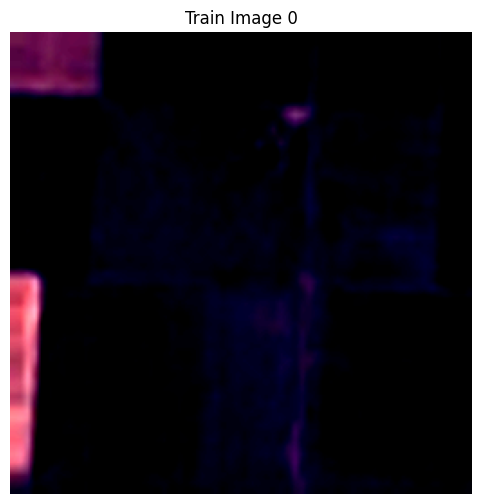

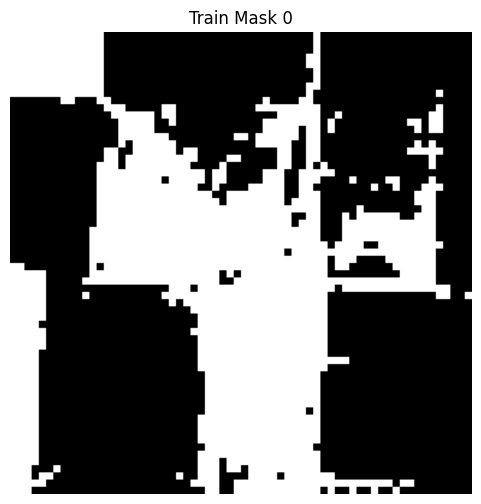

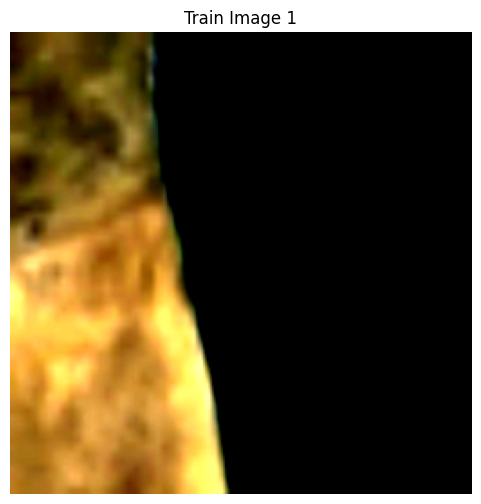

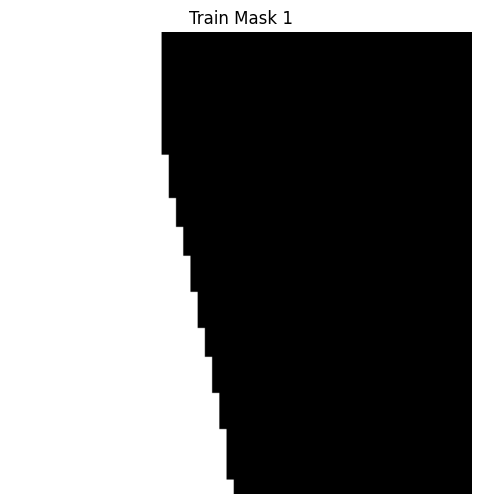

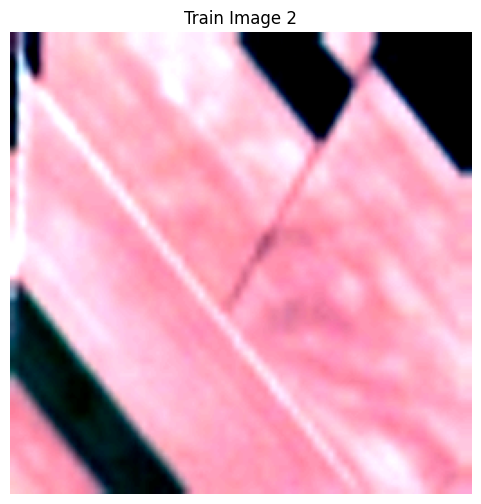

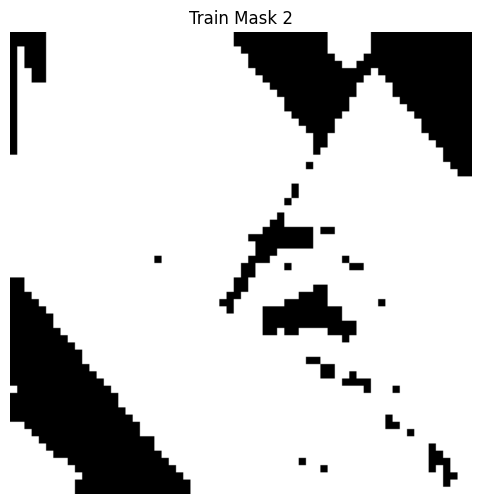

In [22]:
def prepare_mask_for_plot(mask):
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy()

    if mask.ndim == 3:
        if mask.shape[0] == 1:          # single-channel
            return mask[0]
        else:                            # multi-channel
            return mask.transpose(1, 2, 0)
    return mask                         # already 2D

# Show first 3 train samples
for i in range(min(3, len(train_ds))):
    img, mask = train_ds[i]

    # Convert img to NumPy and transpose if needed
    if isinstance(img, torch.Tensor):
        img_to_show = img.cpu().numpy()
    else:
        img_to_show = img

    if img_to_show.ndim == 3 and img_to_show.shape[0] in [1, 3]:
        img_to_show = img_to_show.transpose(1, 2, 0)

    mask_to_show = prepare_mask_for_plot(mask)

    show_image(img_to_show, title=f'Train Image {i}')
    show_image(mask_to_show, title=f'Train Mask {i}')


In [48]:
# Cell 10: Refined TransUNet Model
# --------------------------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm

# ---------------- Patch Embedding ----------------
class PatchEmbed(nn.Module):
    def __init__(self, in_ch=3, embed_dim=256, patch_size=1):
        super().__init__()
        self.proj = nn.Conv2d(in_ch, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # x: B x C x H x W
        x = self.proj(x)  # B x embed_dim x H' x W'
        B, E, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  # B x N x E
        x = self.norm(x)
        return x, (H, W)

# ---------------- Transformer Encoder ----------------
class SimpleTransformerEncoder(nn.Module):
    def __init__(self, embed_dim=256, depth=2, num_heads=8, mlp_ratio=4.0, dropout=0.0):
        super().__init__()
        self.layers = nn.ModuleList()
        for _ in range(depth):
            self.layers.append(nn.ModuleDict({
                'attn': nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True),
                'ln1': nn.LayerNorm(embed_dim),
                'ln2': nn.LayerNorm(embed_dim),
                'mlp': nn.Sequential(
                    nn.Linear(embed_dim, int(embed_dim*mlp_ratio)),
                    nn.GELU(),
                    nn.Linear(int(embed_dim*mlp_ratio), embed_dim)
                )
            }))

    def forward(self, x):
        # x: B x N x E
        for layer in self.layers:
            x_norm = layer['ln1'](x)
            attn_out,_ = layer['attn'](x_norm, x_norm, x_norm)
            x = x + attn_out
            x = x + layer['mlp'](layer['ln2'](x))
        return x

# ---------------- Decoder Block ----------------
class DecoderBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch + skip_ch, out_ch, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)

    def forward(self, x, skip):
        if skip is not None:
            x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=False)
            x = torch.cat([x, skip], dim=1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x

# ---------------- TransUNet ----------------
class TransUNet(nn.Module):
    def __init__(self, num_classes=1, pretrained=True, encoder_name='resnet34', embed_dim=256):
        super().__init__()
        # Encoder
        self.encoder = timm.create_model(encoder_name, pretrained=pretrained, features_only=True, in_chans=3)
        feats = self.encoder.feature_info.channels()  # list of channels shallow->deep

        # Transformer bottleneck
        self.patch_embed = PatchEmbed(in_ch=feats[-1], embed_dim=embed_dim, patch_size=1)
        self.transformer = SimpleTransformerEncoder(embed_dim=embed_dim, depth=2, num_heads=8)
        self.trans_proj = nn.Linear(embed_dim, feats[-1])

        # Decoder
        self.decoder4 = DecoderBlock(in_ch=feats[-1], skip_ch=feats[-2], out_ch=feats[-2])
        self.decoder3 = DecoderBlock(in_ch=feats[-2], skip_ch=feats[-3], out_ch=feats[-3])
        self.decoder2 = DecoderBlock(in_ch=feats[-3], skip_ch=feats[-4], out_ch=feats[-4])
        self.decoder1 = DecoderBlock(in_ch=feats[-4], skip_ch=0, out_ch=feats[-4])

        # Final conv
        self.final_conv = nn.Conv2d(feats[-4], num_classes, kernel_size=1)

    def forward(self, x):
        features = self.encoder(x)       # list of feature maps
        deep = features[-1]

        # Transformer bottleneck
        B, C, H, W = deep.shape
        x_p, (Hp, Wp) = self.patch_embed(deep)
        x_t = self.transformer(x_p)
        x_back = self.trans_proj(x_t).transpose(1,2).reshape(B, C, Hp, Wp)
        x_deep = deep + x_back

        # Decoder
        d4 = self.decoder4(x_deep, features[-2])
        d3 = self.decoder3(d4, features[-3])
        d2 = self.decoder2(d3, features[-4])
        d1 = self.decoder1(d2, None)

        # Output
        out = self.final_conv(d1)
        out = F.interpolate(out, size=x.shape[2:], mode='bilinear', align_corners=False)  # match input size

        if self.final_conv.out_channels == 1:
            out = torch.sigmoid(out)
        else:
            out = F.softmax(out, dim=1)
        return out



In [49]:
# Cell 11: Instantiate model (with PRETRAINED flag)
# --------------------------------------------------
model = TransUNet(num_classes=CFG.NUM_CLASSES, pretrained=CFG.PRETRAINED_ENCODER, encoder_name=CFG.ENCODER_NAME, embed_dim=CFG.TRANSFORMER_EMBED_DIM)
model = model.to(CFG.DEVICE)
print(model)

TransUNet(
  (encoder): FeatureListNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [50]:
# Cell 12: Loss, optimizer, scheduler, label smoothing
# --------------------------------------------------
# Loss: BCEWithLogits if using raw logits; our model outputs sigmoid for binary so use BCE

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # inputs: (B,1,H,W) after sigmoid
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2.*intersection + self.smooth)/(inputs.sum() + targets.sum() + self.smooth)
        return 1 - dice

# Combine BCE + Dice
bce = nn.BCELoss()
dice = DiceLoss()

def get_optimizer(params):
    if CFG.OPTIM.lower()=='adam':
        return torch.optim.Adam(params, lr=CFG.LR, weight_decay=CFG.WEIGHT_DECAY)
    elif CFG.OPTIM.lower()=='adamw':
        return torch.optim.AdamW(params, lr=CFG.LR, weight_decay=CFG.WEIGHT_DECAY)
    elif CFG.OPTIM.lower()=='rmsprop':
        return torch.optim.RMSprop(params, lr=CFG.LR, weight_decay=CFG.WEIGHT_DECAY)
    else:
        return torch.optim.AdamW(params, lr=CFG.LR, weight_decay=CFG.WEIGHT_DECAY)

optimizer = get_optimizer(model.parameters())

# scheduler
if CFG.LR_DECAY:
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=CFG.LR_DECAY_STEP, gamma=CFG.LR_DECAY_GAMMA)
else:
    scheduler = None

# Optionally implement warmup manually in training loop

In [51]:
# Cell 13: Print model and parameter count
# --------------------------------------------------
def count_parameters(module):
    return sum(p.numel() for p in module.parameters() if p.requires_grad)

print('Device:', CFG.DEVICE)
print(model)
print('Trainable params:', count_parameters(model))


Device: cuda
TransUNet(
  (encoder): FeatureListNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), strid

In [61]:
from torchmetrics.classification import BinaryJaccardIndex
from torchmetrics.functional.segmentation import dice_score
import torch
import torch.nn.functional as F
import torch.nn as nn

# ---------------- Training/validation tracking ----------------
train_losses = []
val_losses = []
train_iou_list = []
val_iou_list = []

# IoU metric object for binary segmentation
metric_iou = BinaryJaccardIndex().to(CFG.DEVICE)

# ---------------- Loss Function ----------------
def compute_loss(pred, mask):
    """
    Combined BCE + Dice loss
    pred: sigmoid output (B,1,H,W)
    mask: ground truth (B,H,W) or (B,1,H,W)
    """
    # Ensure mask has channel dimension
    if mask.dim() == 3:
        mask = mask.unsqueeze(1)

    # Resize pred to match mask
    if pred.shape[2:] != mask.shape[2:]:
        pred = F.interpolate(pred, size=mask.shape[2:], mode='bilinear', align_corners=False)

    # BCE Loss
    loss_bce = nn.BCELoss()(pred, mask)

    # Dice Loss
    loss_dice = 1 - dice_score(pred, mask, num_classes=2).mean()

    return loss_bce + loss_dice

# ---------------- Train One Epoch ----------------
def train_one_epoch(model, loader, optimizer, epoch):
    model.train()
    running_loss = 0.0
    metric_iou.reset()
    dice_scores = []

    for imgs, masks in loader:
        imgs = imgs.to(CFG.DEVICE).float()
        masks = masks.to(CFG.DEVICE).float()
        if masks.dim() == 3:
            masks = masks.unsqueeze(1)

        preds = model(imgs)
        loss = compute_loss(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Metrics
        pred_bin = (preds > 0.5).float()
        metric_iou.update(pred_bin, masks)
        dice_val = dice_score(pred_bin, masks, num_classes=1).mean()
        dice_scores.append(dice_val.item())

    avg_loss = running_loss / len(loader)
    avg_iou = metric_iou.compute().item()
    avg_dice = sum(dice_scores) / len(dice_scores)

    print(f"Epoch {epoch} Train Loss: {avg_loss:.4f} IoU: {avg_iou:.4f} Dice: {avg_dice:.4f}")
    return avg_loss, avg_iou, avg_dice

# ---------------- Validation ----------------
def validate(model, loader, epoch):
    model.eval()
    running_loss = 0.0
    metric_iou.reset()
    dice_scores = []

    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.to(CFG.DEVICE).float()
            masks = masks.to(CFG.DEVICE).float()
            if masks.dim() == 3:
                masks = masks.unsqueeze(1)

            preds = model(imgs)
            loss = compute_loss(preds, masks)
            running_loss += loss.item()

            # Metrics
            pred_bin = (preds > 0.5).float()
            metric_iou.update(pred_bin, masks)
            dice_val = dice_score(pred_bin, masks, num_classes=1).mean()
            dice_scores.append(dice_val.item())

    avg_loss = running_loss / len(loader)
    avg_iou = metric_iou.compute().item()
    avg_dice = sum(dice_scores) / len(dice_scores)

    print(f"Epoch {epoch} Val Loss: {avg_loss:.4f} IoU: {avg_iou:.4f} Dice: {avg_dice:.4f}")
    return avg_loss, avg_iou, avg_dice


In [62]:
# ---------------- Run Training Loop with Warmup ----------------
best_val_iou = 0.0

# Initialize Dice lists
train_dice_list = []
val_dice_list = []

for epoch in range(1, CFG.EPOCHS + 1):
    # ---------------- Linear Warmup ----------------
    if CFG.USE_WARMUP and epoch <= CFG.WARMUP_EPOCHS:
        warmup_factor = epoch / CFG.WARMUP_EPOCHS
        for g in optimizer.param_groups:
            g['lr'] = CFG.LR * warmup_factor

    # ---------------- Train & Validate ----------------
    train_loss, train_iou_val, train_dice_val = train_one_epoch(model, train_loader, optimizer, epoch)
    val_loss, val_iou_val, val_dice_val = validate(model, val_loader, epoch)

    # ---------------- Store Metrics ----------------
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_iou_list.append(train_iou_val)
    val_iou_list.append(val_iou_val)
    train_dice_list.append(train_dice_val)
    val_dice_list.append(val_dice_val)

    # ---------------- Scheduler Step ----------------
    if scheduler is not None:
        scheduler.step()

    # ---------------- Save Best Model ----------------
    if CFG.SAVE_MODEL and val_iou_val > best_val_iou:
        best_val_iou = val_iou_val
        save_path = os.path.join(CFG.OUT_DIR, CFG.MODEL_NAME)
        torch.save({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict()
        }, save_path)
        print(f"Saved best model to {save_path}")

    # ---------------- Epoch Summary ----------------
    print(f"Epoch {epoch} Summary | "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Train IoU: {train_iou_val:.4f} | Val IoU: {val_iou_val:.4f} | "
          f"Train Dice: {train_dice_val:.4f} | Val Dice: {val_dice_val:.4f}")


Epoch 1 Train Loss: 0.5268 IoU: 0.6070 Dice: 1.0000
Epoch 1 Val Loss: 0.4402 IoU: 0.6647 Dice: 1.0000
Saved best model to /content/outputs/transunet.pth
Epoch 1 Summary | Train Loss: 0.5268 | Val Loss: 0.4402 | Train IoU: 0.6070 | Val IoU: 0.6647 | Train Dice: 1.0000 | Val Dice: 1.0000
Epoch 2 Train Loss: 0.3672 IoU: 0.7397 Dice: 1.0000
Epoch 2 Val Loss: 0.3739 IoU: 0.7412 Dice: 1.0000
Saved best model to /content/outputs/transunet.pth
Epoch 2 Summary | Train Loss: 0.3672 | Val Loss: 0.3739 | Train IoU: 0.7397 | Val IoU: 0.7412 | Train Dice: 1.0000 | Val Dice: 1.0000
Epoch 3 Train Loss: 0.3022 IoU: 0.7877 Dice: 1.0000
Epoch 3 Val Loss: 0.2807 IoU: 0.8016 Dice: 1.0000
Saved best model to /content/outputs/transunet.pth
Epoch 3 Summary | Train Loss: 0.3022 | Val Loss: 0.2807 | Train IoU: 0.7877 | Val IoU: 0.8016 | Train Dice: 1.0000 | Val Dice: 1.0000
Epoch 4 Train Loss: 0.2670 IoU: 0.8130 Dice: 1.0000
Epoch 4 Val Loss: 0.2647 IoU: 0.8103 Dice: 1.0000
Saved best model to /content/outputs/

Text(0.5, 1.0, 'Loss')

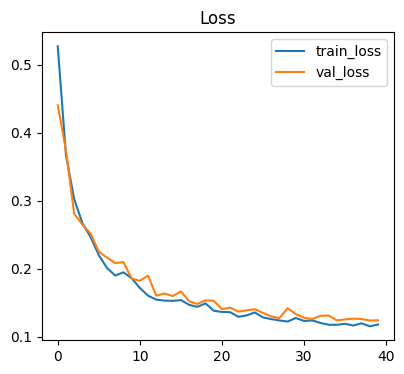

In [65]:

# Cell 16: Plot training curves
# --------------------------------------------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.legend()
plt.title('Loss')



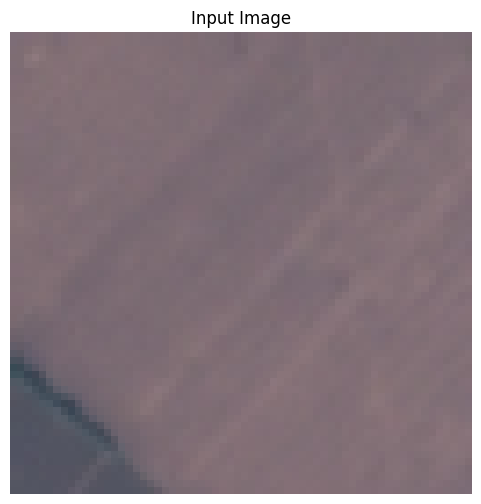

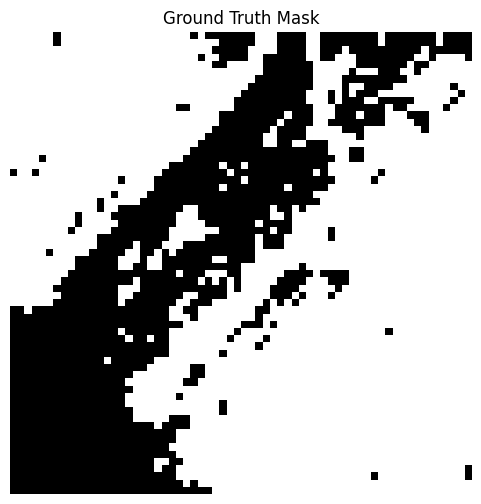

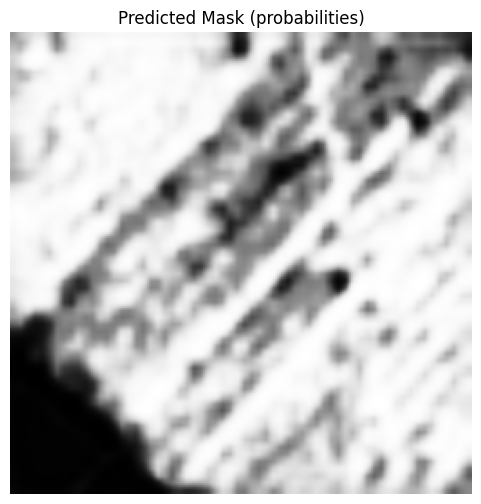

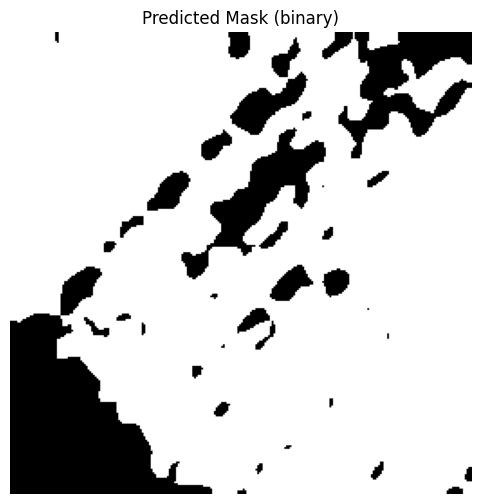

In [66]:

# Cell 17: Evaluate on single image and visualize prediction
# --------------------------------------------------
# Cell 17: Evaluate on single image and visualize prediction
# --------------------------------------------------
import torch
import numpy as np
from PIL import Image

model.eval()

# Load last image-mask pair
img_path, mask_path = paired[-1]

# Load image and mask
img = np.array(Image.open(img_path).convert('RGB'))
mask_gt = np.array(Image.open(mask_path).convert('L'))
mask_gt = (mask_gt > 127).astype(np.uint8)  # binary mask

# Apply validation transforms
aug = val_transform(image=img)
img_t = aug['image'].unsqueeze(0).to(CFG.DEVICE).float()  # (1,C,H,W)

# Forward pass
with torch.no_grad():
    pred = model(img_t)  # (1,1,H,W) for binary segmentation

# Move to CPU and numpy
pred_np = pred.squeeze(0).squeeze(0).cpu().numpy()  # (H,W)

# Binary mask from predicted probabilities
pred_bin = (pred_np > 0.5).astype(np.uint8)

# Visualization helper
def show_image(img, title=''):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,6))
    if img.ndim == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Display
show_image(img, title='Input Image')
show_image(mask_gt, title='Ground Truth Mask')
show_image(pred_np, title='Predicted Mask (probabilities)')
show_image(pred_bin, title='Predicted Mask (binary)')



In [67]:
# Cell 18: Save final model (already saved best) and provide download link
# --------------------------------------------------
if CFG.SAVE_MODEL:
    final_path = os.path.join(CFG.OUT_DIR, 'final_'+CFG.MODEL_NAME)
    torch.save(model.state_dict(), final_path)
    print('Saved final model state dict to', final_path)
    try:
        from google.colab import files
        files.download(final_path)
    except Exception:
        print('If running outside Colab, download from the path above.')

# End of notebook
print('Done. You can modify CFG values at the top to change behavior (augmentations, pretrained, optimizer, etc.)')

Saved final model state dict to /content/outputs/final_transunet.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Done. You can modify CFG values at the top to change behavior (augmentations, pretrained, optimizer, etc.)
